In [7]:
import sys
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import time
from typing import Union, List, Sequence, Optional
from tqdm import trange

# Add the parent directory (project root) to sys.path
script_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(script_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# ------------------------------------------------------------------
#! General
import QES.general_python.common.binary as Binary
from QES.general_python.common.timer import Timer, timeit
from QES.general_python.common.binary import JAX_AVAILABLE, get_backend, get_global_logger
from QES.general_python.common.plot import Plotter, MatrixPrinter

# ------------------------------------------------------------------
#! Lattice
from QES.general_python.lattices import choose_lattice, plot_bonds

# ------------------------------------------------------------------
#! Sampler
import QES.Solver.MonteCarlo.sampler as Sampler
import QES.NQS.nqs as NQS
import QES.NQS.nqs_train as NQST
import QES.NQS.tdvp as TDVP
from QES.general_python.ml.schedulers import EarlyStopping, ConstantScheduler, ExponentialDecayScheduler

# ------------------------------------------------------------------
#! ODE solver
from QES.general_python.algebra.ode import choose_ode

# ------------------------------------------------------------------
#! Networks
from QES.general_python.ml.net_impl.networks.net_rbm import RBM
from QES.general_python.ml.net_impl.networks.net_cnn import CNN
from QES.general_python.ml.net_impl.activation_functions import relu_jnp, tanh_jnp, sigmoid_jnp, leaky_relu_jnp, elu_jnp, poly6_jnp, softplus_jnp

# ------------------------------------------------------------------
#! Hamiltonians
from QES.general_python.algebra.linalg import act, overlap
from QES.Algebra.Model.dummy import DummyHamiltonian
from QES.Algebra.Model.Interacting.Spin.heisenberg_kitaev import HeisenbergKitaev
from QES.Algebra.Model.Interacting.Spin.transverse_ising import TransverseFieldIsing

# ------------------------------------------------------------------
#! Linear algebra
import QES.general_python.algebra.solvers.stochastic_rcnfg as SR
import QES.general_python.algebra.solvers as solvers
import QES.general_python.algebra.preconditioners as preconditioners

# ------------------------------------------------------------------

#! Spin operators
import QES.Algebra.Operator.operators_spin as op_spin
#! Fermionic operators
import QES.Algebra.Operator.operators_spinless_fermions as op_sferm

#! Backends
if JAX_AVAILABLE:
    import jax
    import jax.numpy as jnp
else:
    jax = None
    jnp = None
    
# ------------------------------------------------------------------
lattice_type        = 'honeycomb'
# lattice_type        = 'square'
lx, ly, lz          = 2, 4, 1
# lx, ly, lz          = 10, 1, 1
# ------------------------------------------------------------------
scheduler           = 'ExponentialDecay'
ode_solver_type     = 'Euler'
# ode_solver_type   = 'Heun'
# ode_solver_type   = 'AdaptiveHeun'
# ode_solver_type   = 'RK4'
lr                  = 0.02 # is also dt
# ------------------------------------------------------------------
network_type        = 'RBM'
# network_type        = 'CNN'
alpha               = 2
# ------------------------------------------------------------------
ham_type            = 'HeisenbergKitaev'
# ham_type            = 'TransverseFieldIsing'
# ham_type            = 'DummyHamiltonian'
ham_dtype           = jnp.float32
# ------------------------------------------------------------------

logger              = get_global_logger()
backend             = 'jax'
seed                = 1234
dtypex              = jnp.complex128
be_modules          = get_backend(backend, random=True, seed=seed, scipy=True)
backend_np, (rng, rng_k), backend_sp = be_modules if isinstance(be_modules, tuple) else (be_modules, (None, None), None)

# ------------------------------------------------------------------


### Lattice interface

In [8]:
lattice = choose_lattice(
    typek = lattice_type,
    lx    = lx,
    ly    = ly,
    lz    = lz,
    bc    = 'mbc'
)
ns, mult, st_shape = lattice.ns, lattice.ns // (lx * ly * lz), (lattice.ns, )
lattice.print_forward(logger=logger)

# lattice
# MatrixPrinter.print_matrix(A)

17_05_2025_23-37_47 [INFO] 	->Neighbors of site 0: 3
17_05_2025_23-37_47 [INFO] 		->Neighbor 0 of site 0: -1
17_05_2025_23-37_47 [INFO] 		->Neighbor 1 of site 0: -1
17_05_2025_23-37_47 [INFO] 		->Neighbor 2 of site 0: 1
17_05_2025_23-37_47 [INFO] 	->Neighbors of site 1: 3
17_05_2025_23-37_47 [INFO] 		->Neighbor 0 of site 1: 4
17_05_2025_23-37_47 [INFO] 		->Neighbor 1 of site 1: 2
17_05_2025_23-37_47 [INFO] 		->Neighbor 2 of site 1: -1
17_05_2025_23-37_47 [INFO] 	->Neighbors of site 2: 3
17_05_2025_23-37_47 [INFO] 		->Neighbor 0 of site 2: -1
17_05_2025_23-37_47 [INFO] 		->Neighbor 1 of site 2: -1
17_05_2025_23-37_47 [INFO] 		->Neighbor 2 of site 2: 3
17_05_2025_23-37_47 [INFO] 	->Neighbors of site 3: 3
17_05_2025_23-37_47 [INFO] 		->Neighbor 0 of site 3: 6
17_05_2025_23-37_47 [INFO] 		->Neighbor 1 of site 3: 0
17_05_2025_23-37_47 [INFO] 		->Neighbor 2 of site 3: -1
17_05_2025_23-37_47 [INFO] 	->Neighbors of site 4: 3
17_05_2025_23-37_47 [INFO] 		->Neighbor 0 of site 4: -1
17_05_2025_23

### Operators to test later on

In [9]:
sig_z = op_spin.sig_z(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0]
)

sig_x = op_spin.sig_x(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0]
)

sig_z_c = op_spin.sig_z(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 1]
)

sig_x_c = op_spin.sig_x(
    lattice = lattice,
    ns      = lattice.ns,
    type_act= op_spin.OperatorTypeActing.Global,
    sites   = [0, 1]
)

if lattice.ns == 2:
    matrix_test = np.kron(op_spin._SIG_X, op_spin._SIG_0) * (0.5)
    print('Matrix test:', matrix_test)

### Hamiltonian - Hamiltonian operator $H$ and its expectation value $\langle H \rangle$.

In [10]:
if ham_type == 'HeisenbergKitaev':
    hamil = HeisenbergKitaev(lattice    = lattice,
                        hilbert_space   = None,
                        hx              = 0.0,
                        hz              = 0.0,
                        kx              = 1.0,
                        ky              = 1.0,
                        kz              = 1.0,
                        j               = 1.0,
                        dlt             = 1.0,
                        dtype           = ham_dtype,
                        backend         = backend)

elif ham_type == 'TransverseFieldIsing':
    hamil = TransverseFieldIsing(
                        lattice        = lattice,
                        hilbert_space  = None,
                        hz             = 2.5,
                        hx             = -1.4,
                        # hx             = -0.7,    # same, but we use spin = 1/2
                        j              = 4.0,          
                        # j              = -1.0,    # same, but we use spin = 1/2          
                        dtype          = ham_dtype,
                        backend        = backend
                )
elif ham_type == 'DummyHamiltonian':
    hamil = DummyHamiltonian(
                        lattice        = lattice,
                        hilbert_space  = None,
                        dtype          = ham_dtype,
                        backend        = backend
                )
else:
    raise ValueError(f"Unknown Hamiltonian type: {ham_type}")

logger.title('Hamiltonian', desired_size=150, fill='#', color='red')
hamil

17_05_2025_23-37_51 [INFO] 		->[Hamiltonian] The type of the lattice HON,LatticeBC.MBC,d=2,Ns=16,Lx=2,Ly=4,Lz=1 is not standard. Check your intentions...
17_05_2025_23-37_51 [INFO] 		->[Heisenberg Kitaev Model] Adding non-modifying operator Operator(Sz/L, type_acting=Local, eigval=1.0, type=Other) at site 0 (sites: [0]) with multiplier 0.0
17_05_2025_23-37_51 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator Operator(Sx/L, type_acting=Local, eigval=1.0, type=Other) at site 0 (sites: [0]) with multiplier 0.0
17_05_2025_23-37_51 [INFO] 		->[Heisenberg Kitaev Model] Adding non-modifying operator Operator(Sz/C, type_acting=Correlation, eigval=1.0, type=Other) at site 0 (sites: [0, 1]) with multiplier 1.0
17_05_2025_23-37_51 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator Operator(Sx/C, type_acting=Correlation, eigval=1.0, type=Other) at site 0 (sites: [0, 1]) with multiplier 2.0
17_05_2025_23-37_51 [INFO] 		->[Heisenberg Kitaev Model] Adding modifying operator O

HeiKit(Ns=16, J=1.000, Kx=1.000, Ky=1.000, Kz=1.000, dlt=1.000, hz=0.000, hx=0.000, , LatticeBC.MBC)

In [11]:
if hamil.hilbert_size <= 2**20:
    time0   = time.time()
    hamil.build(use_numpy=True)
    time1   = time.time()
    logger.info(f"Time to build Hamiltonian: {time1 - time0:.2f} seconds", color='green')
    
    if hamil.hilbert_size <= 2**12:
        hamil.diagonalize()
    else:
        hamil.diagonalize(method = 'lanczos', k = 50)
    time2   = time.time()
    logger.info(f"Time to diagonalize Hamiltonian: {time2 - time1:.2f} seconds", color='blue')
    eigv    = hamil.get_eigval()
    
    #! Test the operator expectation in the ground state
    if hamil.hilbert_size <= 2**12:
        gs              = hamil.get_eigvec(0)
        # test energy 
        hamil_mat       = hamil.hamil
        energy_0        = overlap(gs, hamil_mat, backend = np)   
        logger.info(f"Energy of the ground state: {energy_0:.4f}", color='green')
        
        sig_x_op_mat    = sig_x.matrix(dim = hamil.hilbert_size, use_numpy = True)
        sig_z_op_mat    = sig_z.matrix(dim = hamil.hilbert_size, use_numpy = True)
        sig_x_op_mat_c  = sig_x_c.matrix(dim = hamil.hilbert_size, use_numpy = True)
        sig_z_op_mat_c  = sig_z_c.matrix(dim = hamil.hilbert_size, use_numpy = True)

        ed_sig_x_exp    = overlap(gs, sig_x_op_mat, backend = np)
        ed_sig_z_exp    = overlap(gs, sig_z_op_mat, backend = np)
        ed_sig_x_exp_c  = overlap(gs, sig_x_op_mat_c, backend = np)
        ed_sig_z_exp_c  = overlap(gs, sig_z_op_mat_c, backend = np)
        logger.info(f"sig_x expectation value: {ed_sig_x_exp:.4f}", color='green')
        logger.info(f"sig_z expectation value: {ed_sig_z_exp:.4f}", color='green')
        logger.info(f"sig_x expectation value (c): {ed_sig_x_exp_c:.4f}", color='green')
        logger.info(f"sig_z expectation value (c): {ed_sig_z_exp_c:.4f}", color='green')
        
        # tensor product test
else:
    eigv                = None
    ed_sig_x_exp        = None
    ed_sig_z_exp        = None
    ed_sig_x_exp_c      = None
    ed_sig_z_exp_c      = None
    logger.info(f"Cannot diagonalize Hamiltonian: {hamil.hilbert_size} > 2^20", color='red')
    

17_05_2025_23-37_54 [INFO] 			->[Heisenberg Kitaev Model] JAX is available but NumPy is forced...
17_05_2025_23-37_54 [INFO] 		->[Heisenberg Kitaev Model] Calculating the Hamiltonian matrix using NumPy...


ValueError: Failed to build the Hamiltonian matrix. Ensure all operators and spaces are properly set. : CPUDispatcher(<function _getitem at 0x171b093a0>) returned a result with an exception set

#### Plot if needed

In [6]:
if eigv is not None:
    fig, ax = Plotter.get_subplots(
        nrows       = 1,
        ncols       = 1,
        figsize     = (4, 3),
        dpi         = 100,
    )
    x   = np.arange(0, len(eigv))
    y   = eigv
    ax[0].plot(x, y / lattice.ns, 'o', markersize=2)
    ax[0].set_xlabel(r'$\mathcal{e}$')
    ax[0].set_ylabel(r'$E/N_s$')
    ax[0].axhline(eigv[0] / lattice.ns, color='r', linestyle='--', label=f'Ground state {eigv[0] / lattice.ns :.3e}')
    ax[0].legend()

### Network - variational ansatz body $\psi _\theta (s)$ and its gradient $\nabla \psi _\theta (s)$.

In [12]:
if network_type == 'RBM':
    net = RBM(
        input_shape         = st_shape, 
        n_hidden            = int(alpha * ns),
        dtype               = dtypex,
        param_dtype         = dtypex,
        seed                = seed,
        visible_bias        = True,
        bias                = True,
    )
elif network_type == 'CNN':
    net     = CNN(
        input_shape         = st_shape,
        reshape_dims        = (lx, ly * mult),
        features            = (8,) * alpha,
        strides             = [(1, 1)] * alpha,
        kernel_sizes        = [(2, 2)] * alpha,
        activations         = [elu_jnp] * alpha,
        dtype               = dtypex,
        param_dtype         = dtypex,
        final_activation    = elu_jnp,
        seed                = seed,
        output_shape        = (1,)
    )
else:
    raise ValueError(f"Unknown network type: {network_type}")
net

17_05_2025_23-38_30 [INFO] 	->[GeneralNet] Holomorphic check result (||∇Re[f] - i*∇Im[f]|| / ||∇Re[f]|| ≈ 0): True
17_05_2025_23-38_30 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex128, is_complex=True, nparams=560, is_holomorphic=True


ComplexRBM(shape=(16,), hidden=32, bias=on, visible_bias=on, dtype=complex128, params=560, analytic_grad=False, initialized)

### Sampler - sampling from the distribution $p_\theta (s)$.

In [14]:
n_chains        = 5
n_samples       = 100
n_therm_steps   = 25
sampler         = Sampler.MCSampler(
                    net             = net,
                    shape           = st_shape,
                    rng             = rng,
                    rng_k           = rng_k,
                    numchains       = n_chains,
                    numsamples      = n_samples,
                    sweep_steps     = ns,
                    backend         = backend_np,
                    therm_steps     = n_therm_steps,
                    mu              = 2.0,
                    seed            = seed,
                    dtype           = dtypex,
                    statetype       = np.float32,
                    makediffer      = True
                )
do_tests    = False
sampler_fun = sampler.get_sampler_jax()
sampler

MCSampler(shape=(16,), mu=2.0, beta=1.0, therm_steps=25, sweep_steps=16, numsamples=100, numchains=5, backend=jax)

#### Optional tests

In [9]:
%%timeit -r 5 -n 5
if do_tests:
    sampler.sample()

28.4 ns ± 20.9 ns per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [10]:
%%timeit -r 5 -n 5
if do_tests:
    sampler_fun(sampler.states, sampler.rng_k, net.get_params())

43.3 ns ± 41.6 ns per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [11]:
if do_tests:
    samples = sampler.sample()
    samples[1][0].shape

In [12]:
import time 

# seems is 5-10x faster than vmc_jax
def multiple_samples(n):
    samples = []
    for i in range(n):
        start       = time.time()
        samples     = sampler.sample()
        samples[0][0].block_until_ready()
        end         = time.time()
        print(f"Time taken for iteration {i}: {end - start:.4f} seconds")
    return samples

if do_tests:
    samples = multiple_samples(50)

In [13]:
if do_tests:
    x, y, z     = samples
    y_st, y_an  = y
    logger.info(f"y_st: {y_st}, shape: {y_st.shape}")

### Stepper - TDVP stepper for the time evolution of the state $\psi _\theta (s)$.

In [15]:
ode_solver = choose_ode(ode_type = ode_solver_type, backend = backend_np, dt = lr, rhs_prefactor = -1.0)
ode_solver

Euler(dt=0.02, backend=jax, rhs_p=-1.0)

### NQS - neural network quantum state $\psi_\theta (s)$ and its gradient $\nabla \psi_\theta (s)$.

In [16]:
n_epo           = 1000
n_sweep_steps   = ns
n_batch         = 100

# Other
reg             = 1e-1
maxiter         = 1000
tolerance       = 1e-8
use_min_sr      = False

# Solver
solver_id       = solvers.SolverType.SCIPY_CG
precond_id      = preconditioners.PreconditionersTypeSym.JACOBI
precond         = preconditioners.choose_precond(precond_id=precond_id, sigma=reg, backend=backend_np)
# precond_id      = None

tdvp = TDVP.TDVP(
    use_sr          = True,
    use_minsr       = False,
    rhs_prefact     = 1.0,
    sr_lin_solver   = solver_id,
    sr_precond      = precond,
    sr_pinv_tol     = tolerance,
    sr_pinv_cutoff  = 1e-8,
    sr_snr_tol      = tolerance,
    sr_diag_shift   = reg,
    sr_lin_solver_t = solvers.SolverForm.GRAM,
    sr_maxiter      = maxiter,
    backend         = backend_np
)
tdvp

17_05_2025_23-38_49 [INFO] 	->[Jacobi Preconditioner] Resetting backend to: <module 'jax.numpy' from '/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/jax/numpy/__init__.py'>
17_05_2025_23-38_49 [INFO] 		->[Jacobi Preconditioner] JIT compiling apply_gram(r, S, Sp, ...) function...


TDVP(backend=jax,use_sr=True,use_minsr=False,rhs_prefact=1.0,sr_snr_tol=1e-08,sr_pinv_tol=1e-08,sr_diag_shift=0.1,sr_maxiter=1000)

In [17]:
nqs = NQS.NQS(
            net             = net,
            sampler         = sampler,
            hamiltonian     = hamil,
            lower_betas     = None,
            lower_states    = None,
            seed            = seed,
            beta            = 1.0,
            mu              = sampler.get_mu(),
            shape           = st_shape,
            backend         = backend_np,
            batch_size      = n_batch,
            dtype           = dtypex,  
        )
nqs.reset()

nqs_train = NQST.NQSTrainer(
    nqs             = nqs,
    ode_solver      = ode_solver,
    tdvp            = tdvp,
    n_batch         = n_batch,
    lr_scheduler    = ExponentialDecayScheduler(lr, n_epo, lr_decay=1e-2, logger=logger, lr_clamp=1e-2),
    early_stopper   = EarlyStopping(patience = 50, min_delta=1e-3, logger=logger),
    reg_scheduler   = ConstantScheduler(reg, max_epochs=n_epo, lr_clamp=1e-2, logger=logger),
    logger          = logger,
)


nqs

17_05_2025_23-38_50 [INFO] 	->[GeneralNet] Holomorphic check result (||∇Re[f] - i*∇Im[f]|| / ||∇Re[f]|| ≈ 0): True
17_05_2025_23-38_50 [INFO] 	->[GeneralNet] FlaxInterface initialized: dtype=complex128, is_complex=True, nparams=560, is_holomorphic=True
17_05_2025_23-38_50 [INFO] 	->[GeneralNet] Network <class 'QES.general_python.ml.net_impl.networks.net_rbm.RBM'> initialized with forced init.
17_05_2025_23-38_50 [INFO] [ExponentialDecayScheduler] Initialized with initial LR: 2.0000e-02, decay rate: 0.0100
17_05_2025_23-38_50 [INFO] [ConstantScheduler] Initialized with constant LR: 1.0000e-01


NQS(ansatz=FlaxNetInterface(input_dim=16, dtype=complex128, flax_module=_FlaxRBM),sampler=MCSampler:
  - State shape: (16,) (Size: 16)
  - Backend: jax
  - Chains: 5, Samples/Chain: 100
  - Params: mu=2.000, beta=1.000, logprob_fact=0.500
  - Thermalization: 25 sweeps x 16 steps/sweep (102400 total site updates/chain)
  - Sampling: 16 steps/sample (25600 total site updates/chain)
,backend=jax)

In [18]:
nqs_train

NQSTrainer(nqs=NQS(ansatz=FlaxNetInterface(input_dim=16, dtype=complex128, flax_module=_FlaxRBM),sampler=MCSampler:
  - State shape: (16,) (Size: 16)
  - Backend: jax
  - Chains: 5, Samples/Chain: 100
  - Params: mu=2.000, beta=1.000, logprob_fact=0.500
  - Thermalization: 25 sweeps x 16 steps/sweep (102400 total site updates/chain)
  - Sampling: 16 steps/sample (25600 total site updates/chain)
,backend=jax), ode_solver=Euler(dt=0.02, backend=jax, rhs_p=-1.0), tdvp=TDVP(backend=jax,use_sr=True,use_minsr=False,rhs_prefact=1.0,sr_snr_tol=1e-08,sr_pinv_tol=1e-08,sr_diag_shift=0.1,sr_maxiter=1000)

### Test the training of the NQS with a simple Hamiltonian.

In [19]:
history, history_std, timings = nqs_train.train(n_epochs=n_epo, reset=False, use_lr_scheduler=(ode_solver_type=='Euler'), use_reg_scheduler=False)

17_05_2025_23-39_00 [INFO] 	->[EarlyStopping] EarlyStopping reset.


Training:  37%|███▋      | 372/1000 [01:37<02:52,  3.63it/s, E/N=-4.4278e-01-2.5854e-03j ± 1.8844e-01, lr=1.0e-02, sig=1.0e-01, t_sample=1.40e-01s, t_step=1.18e-01s, t_update=8.01e-04s, t_gradient=3.91e-04s, t_prepare=2.19e-02s, t_solve=9.41e-02s, t_total=3.75e-01s]

17_05_2025_23-40_38 [INFO] [EarlyStopping] EarlyStopping: Metric did not improve for 50 epochs. Stopping.
17_05_2025_23-40_38 [INFO] Early stopping at epoch 372.


Training:  37%|███▋      | 372/1000 [01:37<02:45,  3.80it/s, E/N=-4.4278e-01-2.5854e-03j ± 1.8844e-01, lr=1.0e-02, sig=1.0e-01, t_sample=1.40e-01s, t_step=1.18e-01s, t_update=8.01e-04s, t_gradient=3.91e-04s, t_prepare=2.19e-02s, t_solve=9.41e-02s, t_total=3.75e-01s]


17_05_2025_23-40_38 [INFO] Time breakdown (s):
17_05_2025_23-40_38 [INFO] 	->- sampling: 5.45e+01 (56.3%)
17_05_2025_23-40_38 [INFO] 	->- compute : 4.17e+01 (43.1%)
17_05_2025_23-40_38 [INFO] 	->- update  : 6.24e-01 (0.6%)
17_05_2025_23-40_38 [INFO] 	->- prepare : 8.62e+00 (8.9%)
17_05_2025_23-40_38 [INFO] 	->- solve   : 2.98e+01 (30.7%)
17_05_2025_23-40_38 [INFO] 	->- gradient: 1.81e-01 (0.2%)
17_05_2025_23-40_38 [INFO] - total   : 9.68e+01
17_05_2025_23-40_39 [INFO] Saved figure to './data/nqs_train/HeisenbergKitaev/gs_train.png' and JSON to './data/nqs_train/HeisenbergKitaev/'.
17_05_2025_23-40_39 [INFO] 	->Saved parameters to ./data/nqs_train/HeisenbergKitaev/gs_train_info.json
17_05_2025_23-40_39 [WARNING] Failed to save parameters: Object of type complex128 is not JSON serializable
17_05_2025_23-40_39 [WARNING] Parameters are not saved.
17_05_2025_23-40_39 [WARNING] 	->You can save them manually using `nqs.get_params()`.


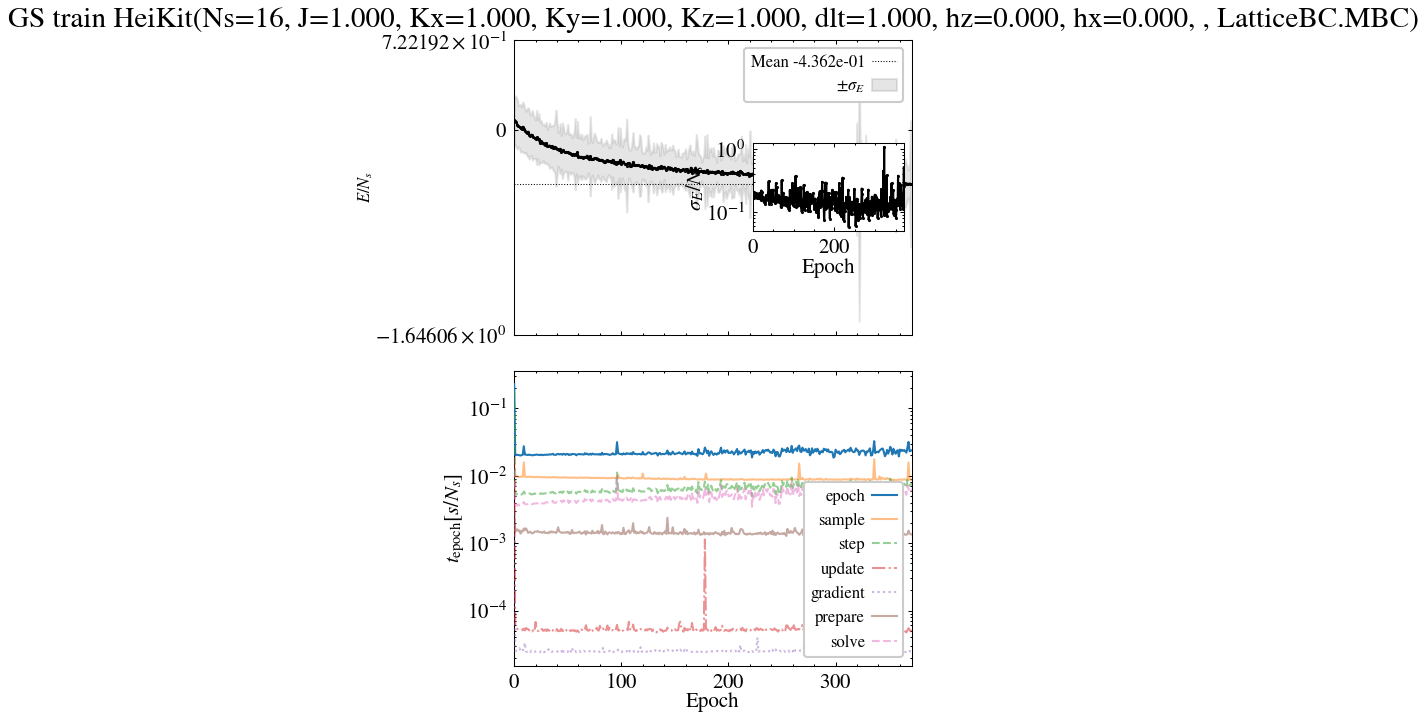

In [20]:
fig, ax = nqs_train.report_gs(eigv=None, last_n=0.05, savedir=f'./data/nqs_train/{ham_type}/')
ax[0].axvline(-18.583590144097595 / lattice.ns, color='r', linestyle='--', label=f'Ground state (DMRG) {-18.583590144097595 / lattice.ns :.3e}')


17_05_2025_22-40_00 [INFO] Operator(Sz/0, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (0.4920+0.0000j) ± (0.0891)  (N=500)
17_05_2025_22-40_00 [INFO] 		->ref = 0.4883 - rel.err = 0.76 %
17_05_2025_22-40_00 [INFO] Operator(Sx/0, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (-0.0874+0.0003j) ± (0.4390)  (N=500)
17_05_2025_22-40_00 [INFO] 		->ref = -0.1074 - rel.err = 18.58 %
17_05_2025_22-40_00 [INFO] Operator(Sz/0-1, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (0.2430+0.0000j) ± (0.0587)  (N=500)
17_05_2025_22-40_00 [INFO] 		->ref = 0.2386 - rel.err = 1.86 %
17_05_2025_22-40_00 [INFO] Operator(Sx/0-1, type_acting=Global, eigval=1.0, type=Other): ⟨O⟩ = (0.0042-0.0015j) ± (0.0294)  (N=500)
17_05_2025_22-40_00 [INFO] 		->ref = 0.0139 - rel.err = 70.61 %
17_05_2025_22-40_00 [INFO] Energy: E = (-2.3203e+01-3.3104e-02j) ± (1.3497) (N=500)
17_05_2025_22-40_00 [INFO] 		->ref = -2.3253e+01 - rel.err = 0.26 %
17_05_2025_22-40_00 [INFO] sample: 4.02e-02 s
17_05_2025_22-40_00 [I

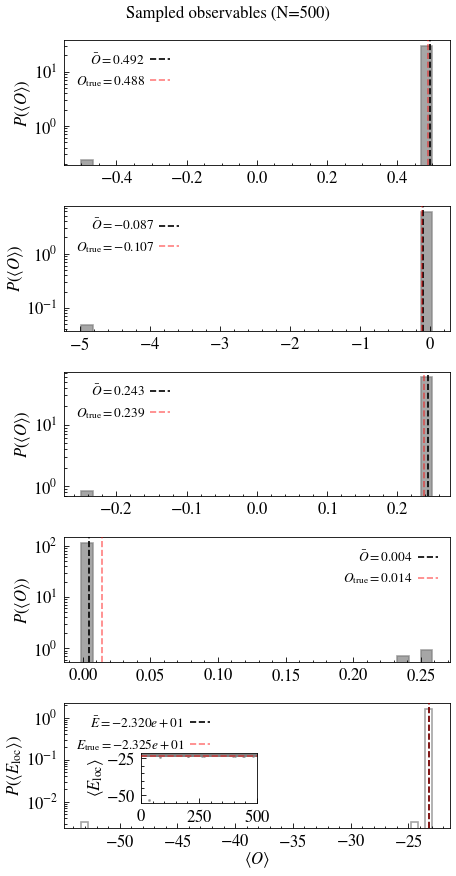

In [ ]:
results, energy, timings = nqs.eval_observables(
    operators      = [sig_z, sig_x, sig_z_c, sig_x_c],
    true_values    = [ed_sig_z_exp, ed_sig_x_exp, ed_sig_z_exp_c, ed_sig_x_exp_c],
    n_chains       = n_chains,
    n_samples      = n_samples,
    batch_size     = 100,
    logger         = logger,
    plot           = True,
    get_energy     = True,
    bins           = 200,
    true_en        = energy_0,
)

### Test modifier

In [ ]:
from QES.Algebra.Operator.operator import initial_states, create_operator

sites_all       = []
operators_inv   = []
# locals
sites           = [0]

operators_inv.append(
    create_operator(
        type_act        =   op_spin.OperatorTypeActing.Global,
        op_func_int     =   None,
        op_func_np      =   None,
        op_func_jnp     =   op_spin.sigma_z_inv_jnp,
        ns              =   lattice.ns,
        sites           =   sites,
        name            =   'sig_z_0',
        extra_args      =   (True, 1.0),
        modifies        =   False,
        
    )
)

operators_inv.append(
    create_operator(
        type_act        =   op_spin.OperatorTypeActing.Global,
        op_func_int     =   None,
        op_func_np      =   None,
        op_func_jnp     =   op_spin.sigma_x_inv_jnp,
        ns              =   lattice.ns,
        sites           =   sites,
        name            =   'sig_x_0',
        extra_args      =   (True, 1.0),
        modifies        =   False,
        
    )
)

# correlations
sites_corr = jnp.array([0, 3], dtype=jnp.int32)
def sig_z_c_modifier(x):
    return op_spin.sigma_z_inv_jnp(x, sites=sites_corr)

def sig_x_c_modifier(x):
    return op_spin.sigma_x_inv_jnp(x, sites=sites_corr)

# k-space
k       = 1.0
sites_k = jnp.arange(0, lattice.ns, dtype=jnp.int32)
def sig_k_modifier(x):
    return op_spin.sigma_k_inv_jnp(x, k=k, sites=sites_k)


names = ['sig_z', 'sig_x', 'sig_z_c', 'sig_x_c', 'sig_k']

sig_z_modifier_jit      = operators_inv[0].jax
sig_x_modifier_jit      = operators_inv[1].jax
sig_z_c_modifier_jit    = jax.jit(sig_z_c_modifier)
sig_x_c_modifier_jit    = jax.jit(sig_x_c_modifier)
sig_k_modifier_jit      = jax.jit(sig_k_modifier)

In [ ]:
# test modifiers
_, _, st_jax = initial_states(lattice.ns, display=True)
st_jax       = (st_jax - 0.5) * 2

In [ ]:
for modifier in [sig_z_modifier_jit, sig_x_modifier_jit]:
    st_out, st_val = modifier(st_jax)
    logger.title('Modifier', desired_size=150, fill='#', color='red')
    logger.info(f"Modified state: {st_out[0]}")
    logger.info(f"Original state: {st_jax}")
    logger.info(f"Modified state value: {st_val}")
    logger.info(f"Modified state shape: {st_out.shape}")

#### $\sigma_z$ - Pauli Z operator at site $i=0$.

In [ ]:
nqs.unset_modifier()
two_states      = jnp.array([st_jax, st_jax], dtype=jnp.float32)
nqs_ansatz_old  = nqs.ansatz
nqs_eval_before = nqs_ansatz_old(nqs.get_params(), two_states)
nqs_eval_before

In [ ]:
nqs.set_modifier(modifier=sig_z_modifier_jit, name=operators_inv[0].name)

Try to evaluate

In [ ]:
nqs_ansatz_new  = nqs.ansatz
nqs_eval_new    = nqs_ansatz_new(nqs.get_params(), two_states)
nqs_eval_new

In [ ]:
results, energy, timings = nqs.eval_observables(
    operators      = [sig_z],
    true_values    = [ed_sig_z_exp],
    n_chains       = n_chains,
    n_samples      = n_samples,
    batch_size     = 100,
    logger         = logger,
    plot           = True,
    get_energy     = True,
    bins           = 200,
    true_en        = energy_0,
)